# Implementation of 2D elasto-plastic problem using FEniCSx 

## Classical approach

This tutorial aims to demonstrate an efficient  The detailed description of the return-mapping algorithm, a weak formulation as well as !!! can be found in the rapport (THE LINK). 

Here we consider a cylinder expansion problem in the two-dimensional case in a symmetric formulation. The domain of the problem represents the quater of cylinder, where symmetry conditions are set on the left and bottom sides and pressure is set on the inner wall (see the picture below). Behavior of elasto-plastic material is defined by von Mises yield criterion with the linear isotropic hardening law.

In order to find numerical solution of target functions (displacements, cumulative plastic strain and stresses) an iterative predictor-corrector return-mapping algorithm is applied. The latter requires the Newton method to solve a nonlinear equation, !!!!!!
Because of specific form of the von Mises criterion the return-mapping procedure can be performed analytically. A detailed conclusion of the von Mises plastic model can be found in (<em> Bonnet et al., (2014). The finite element method in solid mechanics </em>).

The code below is based on a [legacy solution](https://comet-fenics.readthedocs.io/en/latest/demo/2D_plasticity/vonMises_plasticity.py.html) for FEniCS 2019. The difference between the implementation of plasticity modeling described in this tutorial with the legacy version will be discussed here below. The author of this tutorial strongly recommend to take a look at the legacy solution at first.

In [21]:
import meshio
import ufl
from dolfinx import fem, io
from mpi4py import MPI
from petsc4py import PETSc

import time
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")

# Here you can find useful functions aimed at simplifying python programs using `dolfinx` library. 
# For example, the function `fenicsx_support.interpolate_quadrature` is essential for an efficient calculation of ufl-expressions on quadrature elements.   
from src import fenicsx_support as fs 

# Here you can find a set of useful classes that wrap standard approaches to solve linear and non-linear problems via PETSc.
# For example, `plasticity_framework.LinearProblem` 
from src import plasticity_framework as pf

### Reading the mesh

In [22]:
if MPI.COMM_WORLD.rank == 0:
    # Make sure, that you use `msh4` version of your .msh file 
    msh = meshio.read("../mesh/thick_cylinder.msh")

    # Create and save one xdmf-file for the mesh and one file for the facets 
    triangle_mesh = fs.create_mesh(msh, "triangle", prune_z=True)
    line_mesh = fs.create_mesh(msh, "line", prune_z=True)
    meshio.write("thick_cylinder.xdmf", triangle_mesh)
    meshio.write("mt.xdmf", line_mesh)
    print(msh)
    


<meshio mesh object>
  Number of points: 811
  Number of cells:
    line: 10
    line: 69
    line: 10
    line: 53
    triangle: 1478
  Cell sets: gmsh:bounding_entities
  Point data: gmsh:dim_tags
  Cell data: gmsh:physical, gmsh:geometrical


In [23]:
with io.XDMFFile(MPI.COMM_WORLD, "thick_cylinder.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    ct = xdmf.read_meshtags(mesh, name="Grid")

mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim - 1)

with io.XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "r") as xdmf:
    ft = xdmf.read_meshtags(mesh, name="Grid")

### Parameters of the problem 

In [24]:
E = 70e3 # [Pa] Young's modulus
nu = 0.3 # [-] Poisson's ratio 

lambda_ = E*nu/(1+nu)/(1-2*nu) # [Pa] Lamé's first parameter
mu_ = E/2./(1+nu) # [Pa] shear modulus

sig0 = 250 # [Pa] yield strength
Et = E/100. # [Pa] tangent modulus
H = E*Et/(E-Et) # [-] hardening modulus

Re, Ri = 1.3, 1. # [m] external and internal radii

### Defining finite element functional spaces

Displacement vector is defined in a standard CG space, whilst such internal variable as stresses and plastic strain involve functional spaces based on Quadrature elements. The latter allow to perform the interpolation of stresses and plastic strain expressions at Gauss points. In the [legacy version](https://comet-fenics.readthedocs.io/en/latest/demo/2D_plasticity/vonMises_plasticity.py.html) a local projection procedure was used to project internal variables onto Quadrature functional spaces. FEniCSx provides functionality to interpolate directly the nonlinear expressions of stresses and plastic strain at Gauss points, which makes the code more efficient. This feature is the only difference between the implementation from this tutorial and the legacy version.

In [25]:
deg_u = 2
deg_stress = 2

# Functional space for displacements
V = fem.VectorFunctionSpace(mesh, ("CG", deg_u))

We = ufl.VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=4, quad_scheme='default')
W0e = ufl.FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')

# Functional space for stress vector
# Here we use Voigt notation to collect 4 components of the stress tensor
W = fem.FunctionSpace(mesh, We)
# Functional space for scalar internal variables such as cumulative plastic strain
W0 = fem.FunctionSpace(mesh, W0e)

In [26]:
sig = fem.Function(W, name="Stress_vector")
sig_old = fem.Function(W, name="Stress_vector_from_previous_step")
p = fem.Function(W0, name="Cumulative_plastic_strain")
dp = fem.Function(W0, name="Cumulative_plastic_strain_increment")
n_elas = fem.Function(W, name="Normal_to_yield_surface")
beta = fem.Function(W0, name="beta")
u = fem.Function(V, name="Total_displacement")
du = fem.Function(V, name="Iteration_correction")
Du = fem.Function(V, name="Current_increment")
v_ = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)

P0 = fem.FunctionSpace(mesh, ("DG", 0))
p_avg = fem.Function(P0, name="Cumulative_plastic_strain_average")

### Marking boundary elements for Dirichlet boundary conditions

In [27]:
left_marker = 3
down_marker = 1
left_facets = ft.indices[ft.values == left_marker]
down_facets = ft.indices[ft.values == down_marker]
left_dofs = fem.locate_dofs_topological(V.sub(0), mesh.topology.dim-1, left_facets)
down_dofs = fem.locate_dofs_topological(V.sub(1), mesh.topology.dim-1, down_facets)

bcs = [fem.dirichletbc(PETSc.ScalarType(0), left_dofs, V.sub(0)), fem.dirichletbc(PETSc.ScalarType(0), down_dofs, V.sub(1))]

### Defining useful UFL expressions 

In [28]:
n = ufl.FacetNormal(mesh)
q_lim = float(2/np.sqrt(3)*np.log(Re/Ri)*sig0) # the analytical collapse load for a perfectly-plastic material (without hardening)
loading = fem.Constant(mesh, PETSc.ScalarType(0.0 * q_lim))

def F_ext(v):
    """External force representing pressure acting on the inner wall of the cylinder."""
    return -loading * ufl.inner(n, v)*ds(4)

def eps(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_tensor([[e[0, 0], e[0, 1], 0],
                          [e[0, 1], e[1, 1], 0],
                          [0, 0, 0]])

def sigma(eps_el):
    return lambda_*ufl.tr(eps_el)*ufl.Identity(3) + 2*mu_*eps_el

def as_3D_tensor(X):
    return ufl.as_tensor([[X[0], X[3], 0],
                          [X[3], X[1], 0],
                          [0, 0, X[2]]])

ppos = lambda x: (x + ufl.sqrt(x**2))/2.
def proj_sig(deps, old_sig, old_p):
    """Performs the predictor-corrector return mapping algorithm.

    This particular algorithm is analytical and based on the von Mises plasticity model with linear isotropic hardening.

    Args:
        deps: ufl 3x3 tensor of the current strain state 
        old_sig: fem.Function variable of the previous stress state 
        old_p: fem.Function variable of the cumulative plastic strain from the previous loading step

    Returns:
        ufl vector of 4 components of the stress tensor in Voigt notation
        ufl vector of 4 components of the normal vector to a yield surface
        beta: ufl expression of a support variable
        dp: ufl expression of the cumulative plastic strain increment 
    """
    sig_n = as_3D_tensor(old_sig)
    sig_elas = sig_n + sigma(deps)
    s = ufl.dev(sig_elas)
    sig_eq = ufl.sqrt(3/2.*ufl.inner(s, s))
    f_elas = sig_eq - sig0 - H*old_p
    dp = ppos(f_elas)/(3*mu_+H)
    n_elas = s/sig_eq*ppos(f_elas)/f_elas
    beta = 3*mu_*dp/sig_eq
    new_sig = sig_elas-beta*s
    return ufl.as_vector([new_sig[0, 0], new_sig[1, 1], new_sig[2, 2], new_sig[0, 1]]), \
           ufl.as_vector([n_elas[0, 0], n_elas[1, 1], n_elas[2, 2], n_elas[0, 1]]), \
           beta, dp       

def sigma_tang(e):
    """Returns an ufl expression of the tangent stress.

    This expression is required for the variational problem in order to update its bilinear part on each iteration of the Newton method.

    Args:
        e: ufl 3x3 tensor of the current strain state 
    """
    N_elas = as_3D_tensor(n_elas)
    return sigma(e) - 3*mu_*(3*mu_/(3*mu_+H)-beta)*ufl.inner(N_elas, e)*N_elas - 2*mu_*beta*ufl.dev(e)  

### Defining the variational and linear problems

In [29]:
ds = ufl.Measure("ds", domain=mesh, subdomain_data=ft)
dx = ufl.Measure(
    "dx",
    domain=mesh,
    metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"},
)

a_Newton = ufl.inner(eps(v_), sigma_tang(eps(u_)))*dx
res = -ufl.inner(eps(u_), as_3D_tensor(sig))*dx + F_ext(u_)

my_problem = pf.LinearProblem(a_Newton, res, Du, bcs)

### Solving the problem

In [30]:
# Defining a cell containing (Ri, 0) point, where we calculate a value of u
# It is required to run this program via MPI in order to capture the process, to which this point is attached 

x_point = np.array([[Ri, 0, 0]])
cells, points_on_proc = fs.find_cell_by_point(mesh, x_point)

Nitermax, tol = 200, 1e-8  # parameters of the manual Newton method
Nincr = 20
load_steps = np.linspace(0, 1.1, Nincr+1)[1:]**0.5
results = np.zeros((Nincr+1, 2))
xdmf = io.XDMFFile(MPI.COMM_WORLD, "output.xdmf", "w", encoding=io.XDMFFile.Encoding.HDF5)
xdmf.write_mesh(mesh)

sig.vector.set(0.0)
sig_old.vector.set(0.0)
p.vector.set(0.0)
u.vector.set(0.0)
n_elas.vector.set(0.0)
beta.vector.set(0.0)

deps = eps(Du)
sig_, n_elas_, beta_, dp_ = proj_sig(deps, sig_old, p)

my_problem.assemble_matrix()

start = time.time()

for (i, t) in enumerate(load_steps):
    loading.value = t * q_lim

    my_problem.assemble_vector()

    nRes0 = my_problem.b.norm() 
    nRes = nRes0
    Du.x.array[:] = 0

    if MPI.COMM_WORLD.rank == 0:
        print(f"\nnRes0 , {nRes0} \n Increment: {str(i+1)}, load = {t * q_lim}")
    niter = 0

    while nRes/nRes0 > tol and niter < Nitermax:
        my_problem.solve(du)

        Du.vector.axpy(1, du.vector) # Du = Du + 1*du
        Du.x.scatter_forward() 

        fs.interpolate_quadrature(sig_, sig)
        fs.interpolate_quadrature(n_elas_, n_elas)
        fs.interpolate_quadrature(beta_, beta)

        my_problem.assemble()

        nRes = my_problem.b.norm() 

        if MPI.COMM_WORLD.rank == 0:
            print(f"    Residual: {nRes}")
        niter += 1
    u.vector.axpy(1, Du.vector) # u = u + 1*Du
    u.x.scatter_forward()

    fs.interpolate_quadrature(dp_, dp)
    p.vector.axpy(1, dp.vector)
    p.x.scatter_forward()
    
    sig_old.x.array[:] = sig.x.array[:]

    fs.project(p, p_avg)
    
    xdmf.write_function(u, t)
    xdmf.write_function(p_avg, t)

    if len(points_on_proc) > 0:
        results[i+1, :] = (u.eval(points_on_proc, cells)[0], t)

xdmf.close()
print(f'rank#{MPI.COMM_WORLD.rank}: Time = {time.time() - start:.3f} (s)')


nRes0 , 4.0766891205717435e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 6.600865392341657e-17

nRes0 , 1.6886199233191777e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 2.7011205694910128e-17

nRes0 , 1.2957236396019523e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 2.0876359543010072e-17

nRes0 , 1.0923455576498115e-05 
 Increment: 4, load = 0.0005074898477471342
    Residual: 1.7702310600942534e-17

nRes0 , 9.623757555886461e-06 
 Increment: 5, load = 0.0005673908987268053
    Residual: 1.5761994118984013e-17

nRes0 , 8.700541886238963e-06 
 Increment: 6, load = 0.000621545588311601
    Residual: 1.4185840087841806e-17

nRes0 , 8.000974001990804e-06 
 Increment: 7, load = 0.0006713459650144749
    Residual: 1.2785623368479297e-17

nRes0 , 7.447125022272689e-06 
 Increment: 8, load = 0.0007176990254506543
    Residual: 1.1724222317202976e-17

nRes0 , 6.994492739323565e-06 
 Increment: 9, load = 0.0007612347716207013
    Residual: 1.1

### Post-processing 

Values of the displacement $u_x$ of the inner boundary at ($R_i$, 0) point were collected at the end of each loading step 

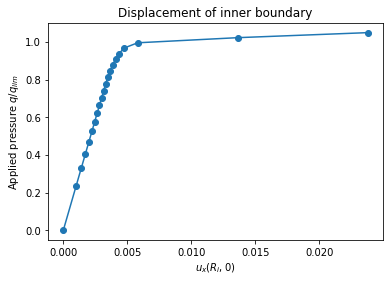

In [31]:
if len(points_on_proc) > 0:
    plt.plot(results[:, 0], results[:, 1], "-o")
    plt.title("Displacement of inner boundary")
    plt.xlabel(r"$u_x(R_i,0)$")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.savefig(f"displacement_rank{MPI.COMM_WORLD.rank:d}.png")
    plt.show()

## Miscellaneous: replacement of manual Newton solver by SNES

### Defining useful UFL expressions 

$$
    R = \int\limits_\Omega \underline{\underline{\sigma}}_{n+1}
$$

In [32]:
def proj_sig_SNES(Du, old_sig, old_p):
    sig_n = as_3D_tensor(old_sig)
    sig_elas = sig_n + sigma(eps(Du))
    s = ufl.dev(sig_elas)
    sig_eq = ufl.sqrt(3/2.*ufl.inner(s, s))
    f_elas = sig_eq - sig0 - H*old_p
    # dp = ufl.conditional(f_elas > 0, f_elas/(3*mu+H), 0)
    dp = ppos(f_elas)/(3*mu_ + H)
    beta = ufl.conditional(f_elas > 0, 3*mu_*dp/sig_eq, 0)
    new_sig = sig_elas-beta*s
    return ufl.as_vector([new_sig[0, 0], new_sig[1, 1], new_sig[2, 2], new_sig[0, 1]]), \
           dp

def deps_p(deps, old_sig, old_p):
    sig_n = as_3D_tensor(old_sig)
    sig_elas = sig_n + sigma(deps)
    s = ufl.dev(sig_elas)
    sig_eq = ufl.sqrt(3/2.*ufl.inner(s, s))
    f_elas = sig_eq - sig0 - H*old_p
    dp_sig_eq = ufl.conditional(f_elas > 0, f_elas/(3*mu_ + H)/sig_eq, 0) # Note: sig_eq is equal to 0 on the first iteration
    # dp = ppos(f_elas)/(3*mu+H) # this approach doesn't work with ufl.derivate
    return 3./2. * dp_sig_eq * s 

### Numerical parameters of SNES solvers

In [33]:
petsc_options_SNES = {
    "snes_type": "vinewtonrsls",
    "snes_linesearch_type": "basic",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-08,
    "snes_rtol": 1.0e-08,
    "snes_stol": 0.0,
    "snes_max_it": 500,
    "snes_monitor": "",
    # "snes_monitor_cancel": "",
}

petsc_options_SNESQN = {
    "snes_type": "qn",
    "snes_qn_type": "lbfgs", #<lbfgs, broyden, badbroyden>
    "snes_qn_m": 100,
    "snes_qn_scale_type": "jacobian", #<diagonal,none,scalar,jacobian> 	
    "snes_qn_restart_type": "none", 
    "pc_type": "cholesky", #<cholesky, hypre, gamg,sor ; asm, lu, ...>
    "snes_linesearch_type": "basic",
    "ksp_type": "preonly",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-08,
    "snes_rtol": 1.0e-08,
    "snes_stol": 0.0,
    "snes_max_it": 500,
    # "snes_monitor": "",
    "snes_monitor_cancel": "",
}

In [34]:
residual = ufl.inner(as_3D_tensor(sig) + sigma(eps(Du) - deps_p(eps(Du), sig, p)), eps(u_))*dx - F_ext(u_)

J = ufl.derivative(ufl.inner(sigma(eps(Du) - deps_p(eps(Du), sig, p)), eps(u_))*dx, Du, v_)
my_problem = pf.SNESProblem(residual, Du, J, bcs, petsc_options=petsc_options_SNES)

# In the case of the quasi-Newton method we have to provide an initial Jacobian value to the solver.
# On the first loading step there is an elastic response only, so we always know this initial value and it is proportional to an elastic stiffness matrix.
# Uncomment lines below to test the quasi-Newton method.

# J_QN = ufl.derivative(ufl.inner(sigma(eps(Du)), eps(u_))*dx, Du, v_)
# my_problem = pf.SNESProblem(residual, Du, J_QN, bcs, petsc_options=petsc_options_SNESQN)

In [35]:
results_SNES = np.zeros((Nincr+1, 2))

sig.vector.set(0.0)
p.vector.set(0.0)
u.vector.set(0.0)

sig_, dp_ = proj_sig_SNES(Du, sig, p)

start = time.time()

for (i, t) in enumerate(load_steps):
    loading.value = t * q_lim

    Du.x.array[:] = 0

    nits = my_problem.solve()

    if MPI.COMM_WORLD.rank == 0:
        print(f"\n Increment: {str(i+1)}, load = {t * q_lim}")
   
    fs.interpolate_quadrature(sig_, sig)
    fs.interpolate_quadrature(dp_, dp)
    
    p.vector.axpy(1, dp.vector)
    p.x.scatter_forward()
    u.vector.axpy(1, Du.vector) # u = u + 1*Du
    u.x.scatter_forward()

    if len(points_on_proc) > 0:
        results_SNES[i+1, :] = (u.eval(points_on_proc, cells)[0], t)

print(f'rank#{MPI.COMM_WORLD.rank}: Time = {time.time() - start:.3f} (s)')

  0 SNES Function norm 4.076689120572e-05 
  1 SNES Function norm 4.196152685008e-17 

 Increment: 1, load = 0.0002537449238735671
  0 SNES Function norm 1.688619923319e-05 
  1 SNES Function norm 1.737642291889e-17 

 Increment: 2, load = 0.00035884951272532715
  0 SNES Function norm 1.295723639602e-05 
  1 SNES Function norm 1.355870561097e-17 

 Increment: 3, load = 0.0004394991003117152
  0 SNES Function norm 1.092345557650e-05 
  1 SNES Function norm 1.122479344653e-17 

 Increment: 4, load = 0.0005074898477471342
  0 SNES Function norm 9.623757555887e-06 
  1 SNES Function norm 9.826898729206e-18 

 Increment: 5, load = 0.0005673908987268053
  0 SNES Function norm 8.700541886239e-06 
  1 SNES Function norm 9.021729598350e-18 

 Increment: 6, load = 0.000621545588311601
  0 SNES Function norm 8.000974001991e-06 
  1 SNES Function norm 8.245029464810e-18 

 Increment: 7, load = 0.0006713459650144749
  0 SNES Function norm 7.447125022273e-06 
  1 SNES Function norm 7.959668094410e-1

### Post-processing 

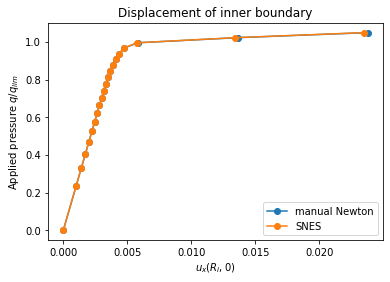

In [36]:
if len(points_on_proc) > 0:
    plt.plot(results[:, 0], results[:, 1], "-o", label="manual Newton")
    plt.plot(results_SNES[:, 0], results_SNES[:, 1], "-o", label="SNES")
    plt.title("Displacement of inner boundary")
    plt.xlabel(r"$u_x(R_i,0)$")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.legend()
    plt.savefig(f"displacement_rank{MPI.COMM_WORLD.rank:d}.png")
    plt.show()